## Preprocessing Audio Data

In this Notebook, we're going to preprocess the audio data from the Nsynth dataset. To being able to process it in two different types of models.

We're going to create Spectrograms to further apply a Convolusional Neural Network with them, and also extracting the Mel Frequency Cepstrum Coefficients. 

We created a SoundProcessor class, to be able to extract the waveform, Short Term Fourier Transformation, and then creating and saving the spectrograms into specific folders for further analysis.

The class is also able to create DataFrame from the WAV files with the MFCCs from each one of them, resulting in a dataset ready to be inputed in a regular Machine Learning model.

In [1]:
#Importing necessary packages

from functions_classes import SoundProcessor, downsampling_df, split_into_separate_dataframes
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import gc 

In [2]:
# Creating the Dataframes out of the Json files.

#Establishing paths

train_path = 'data/train/examples.json'
test_path = 'data/test/examples.json'
valid_path = 'data/valid/examples.json'

# Defining dataframes

train_df = pd.read_json(train_path).transpose()
test_df = pd.read_json(test_path).transpose()
valid_df = pd.read_json(valid_path).transpose()

In [3]:
#Defining paths to get the audio files

train_audio_folder = 'data/train/audio'
test_audio_folder = 'data/test/audio'
valid_audio_folder = 'data/valid/audio'

#Defining paths to store the spectrograms.

train_specs_path = 'data/train/spectrograms'
test_specs_path = 'data/test/spectrograms'

In [4]:
train_df.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
guitar_acoustic_001-082-050,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
bass_synthetic_120-108-050,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,[percussive],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
organ_electronic_120-050-127,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
guitar_electronic_021-026-025,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
organ_electronic_011-079-075,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [5]:
train_df.columns

Index(['note', 'sample_rate', 'pitch', 'instrument_source',
       'instrument_family_str', 'instrument_str', 'note_str', 'qualities_str',
       'instrument_source_str', 'velocity', 'instrument_family', 'instrument',
       'qualities'],
      dtype='object')

In [6]:
train_df['instrument_family_str'].value_counts(normalize=True)

bass          0.226393
keyboard      0.179184
organ         0.119213
mallet        0.118259
guitar        0.113034
string        0.067336
reed          0.048101
brass         0.043827
vocal         0.035297
flute         0.030335
synth_lead    0.019021
Name: instrument_family_str, dtype: float64

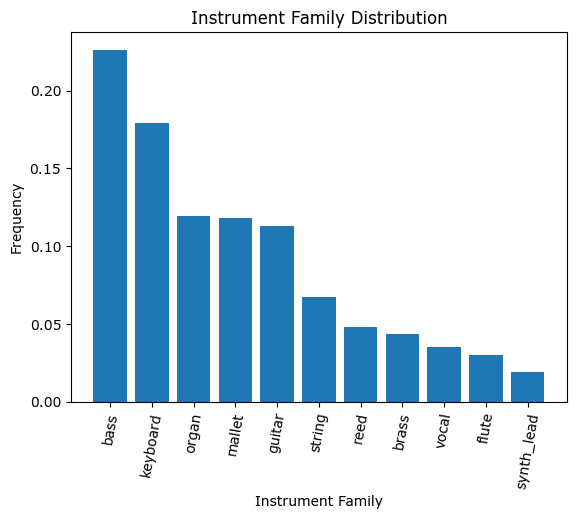

In [7]:
plt.bar(train_df['instrument_family_str'].value_counts().index, train_df['instrument_family_str'].value_counts(normalize=True))
plt.xlabel('Instrument Family')
plt.ylabel('Frequency')
plt.title('Instrument Family Distribution')
plt.xticks(rotation=80);

We can see that the dataset is very unbalanced. Therefore we created a downsampling function to make it more suitable for our models. We decided to have it closer to a balanced data.

In [9]:
#Downsampling the Train data
train_df_downsampled = downsampling_df(train_df,7000,train_df['instrument_family_str'].unique(),'instrument_family_str')

# Shuffling the resulting downsampled dataset
train_df_d = train_df_downsampled.sample(frac=1, random_state=42)
train_df_downsampled['instrument_family_str'].value_counts(normalize=True)


guitar        0.092714
bass          0.092714
organ         0.092714
keyboard      0.092714
vocal         0.092714
string        0.092714
reed          0.092714
flute         0.092714
mallet        0.092714
brass         0.092714
synth_lead    0.072860
Name: instrument_family_str, dtype: float64

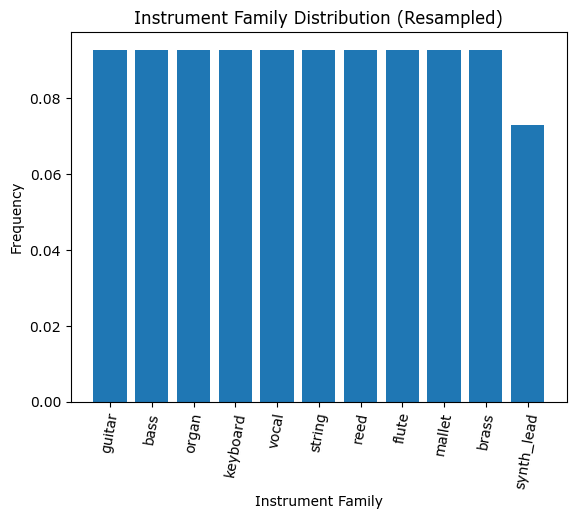

In [11]:
plt.bar(train_df_downsampled['instrument_family_str'].value_counts().index, train_df_downsampled['instrument_family_str'].value_counts(normalize=True))
plt.xlabel('Instrument Family')
plt.ylabel('Frequency')
plt.title('Instrument Family Distribution (Resampled)')
plt.xticks(rotation=80);

Now, we have a balanced dataset. This is the one we'll input in our class to extract the necessary information.

In [21]:
#Extracting the MFCCs data frames and converting them into CSVs for further analysis.

train_sound = SoundProcessor(train_df_d, train_audio_folder, 'instrument_family')
train_mfcc = train_sound.mfcc()
train_mfcc.to_csv('train_mfcc.csv', index=False)


valid_sound = SoundProcessor(valid_df, valid_audio_folder,'instrument_family')
valid_mfcc = valid_sound.mfcc()
valid_mfcc.to_csv('valid_mfcc.csv', index=False)


test_sound = SoundProcessor(test_df, test_audio_folder,'instrument_family')
test_mfcc = test_sound.mfcc()
test_mfcc.to_csv('test_mfcc.csv', index=False)

## The problem with the big dataset

With This dataset, we tried to input it in the Class and it crashed the notebook every single time we tried. So after many iterations I created a function to split the dataframes into chunks that'll be processed individually for the Class.

I set up a chunk size of 2000 rows to be able to go through each one of them individually.

In [14]:
split_into_separate_dataframes(train_df_d, 2000)

Created variables: ['train_df_1', 'train_df_2', 'train_df_3', 'train_df_4', 'train_df_5', 'train_df_6', 'train_df_7', 'train_df_8', 'train_df_9', 'train_df_10', 'train_df_11', 'train_df_12', 'train_df_13', 'train_df_14', 'train_df_15', 'train_df_16', 'train_df_17', 'train_df_18', 'train_df_19', 'train_df_20', 'train_df_21', 'train_df_22', 'train_df_23', 'train_df_24', 'train_df_25', 'train_df_26', 'train_df_27', 'train_df_28', 'train_df_29', 'train_df_30', 'train_df_31', 'train_df_32', 'train_df_33', 'train_df_34', 'train_df_35', 'train_df_36', 'train_df_37', 'train_df_38']


['train_df_1',
 'train_df_2',
 'train_df_3',
 'train_df_4',
 'train_df_5',
 'train_df_6',
 'train_df_7',
 'train_df_8',
 'train_df_9',
 'train_df_10',
 'train_df_11',
 'train_df_12',
 'train_df_13',
 'train_df_14',
 'train_df_15',
 'train_df_16',
 'train_df_17',
 'train_df_18',
 'train_df_19',
 'train_df_20',
 'train_df_21',
 'train_df_22',
 'train_df_23',
 'train_df_24',
 'train_df_25',
 'train_df_26',
 'train_df_27',
 'train_df_28',
 'train_df_29',
 'train_df_30',
 'train_df_31',
 'train_df_32',
 'train_df_33',
 'train_df_34',
 'train_df_35',
 'train_df_36',
 'train_df_37',
 'train_df_38']

In [ ]:
# Looping through the different chunks of the training data and processing it.
for train_chunk in variable_names:
    train_sound = SoundProcessor(train_chunk, train_audio_folder, 'instrument_family')
    train_sound.process_and_save_spectrograms(train_specs_path)

In [59]:
# Creating spectrograms for the test data
test_sound = SoundProcessor(test_df, test_audio_folder,'instrument_family')
test_sound.process_and_save_spectrograms(test_specs_path)

<Figure size 640x480 with 0 Axes>

In [60]:
#Creating Spectrograms for the validation data
# In this case we're sending the spectrograms to the same folder as the training data.
# We'll split it later in the neural network process, to avoid label issues moving forward

valid_sound = SoundProcessor(valid_df, valid_audio_folder,'instrument_family')
valid_sound.process_and_save_spectrograms(train_specs_path)

<Figure size 640x480 with 0 Axes>